In [5]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
print(cv2.__version__)
import numpy as np

3.3.1


In [6]:
path = "D:\Moth Learning Project\Flower shape Experiment Data\TipManualDigitization"

In [7]:
trackframe_filename = 'ManualTipTRacking_DigitizingChart.xlsx'

In [8]:
frameInfo = pd.read_excel(path + "\\" + trackframe_filename)

In [9]:
frameInfo

,Name,Date,trial,Start,Frame Start,Digitized Start,Stop,Frame Stop,Digitized Stop
0,c-1_m13,2018-03-13,0,11:15:00,20070,20455.0,12:00:00,21600,21200.0
1,c-1_m13,2018-03-13,last,1900-01-01 16:25:00,72450,NaN,1900-01-01 17:09:00,73962,NaN
2,c-2_m5,2018-02-20,0,12:40:00,22320,NaN,13:34:00,24012,NaN
3,c-2_m5,2018-02-20,last,1900-01-01 11:10:00,63180,NaN,1900-01-01 11:42:00,63756,NaN
4,c-3_m10,2018-03-01,0,11:15:00,20070,20390.0,12:02:00,21636,21150.0
5,c-3_m10,2018-03-01,last,1900-01-02 11:40:00,106920,107670.0,01:00:10,108000,107770.0
6,c-10_m11,2018-03-08,0,05:20:00,9360,NaN,06:45:00,11610,NaN
7,c-10_m11,2018-03-08,last,01:41:00,181800,NaN,01:41:34,182412,NaN


Get the tracks coordinates

In [10]:
name = 'c-3_m10'
t0_startFrame = 20390
t0_stopFrame = 21150
tlast_startFrame = 107670
tlast_stopFrame = 107770

In [11]:
filepath = glob.glob(path + "\\" + "*" + name + "xypts.csv")

In [12]:
xypts = pd.read_csv(filepath[0])
xypts.columns

Index(['pt1_cam1_X', 'pt1_cam1_Y', 'pt2_cam1_X', 'pt2_cam1_Y', 'pt3_cam1_X',
       'pt3_cam1_Y', 'pt4_cam1_X', 'pt4_cam1_Y', 'pt5_cam1_X', 'pt5_cam1_Y'],
      dtype='object')

In [13]:
trial0 = xypts.loc[t0_startFrame:t0_stopFrame,'pt4_cam1_X':'pt4_cam1_Y']
trial_last = xypts.loc[tlast_startFrame:tlast_stopFrame,'pt4_cam1_X':'pt4_cam1_Y']

Get the video frame

In [14]:
pathForVideo = "D:\Moth Learning Project\AllVideosForAnalysis\CompliedDataForAnalysis"
videopath = glob.glob(pathForVideo + "\**\\" + name + ".mp4", recursive=True)

In [15]:
videopath[0]

"D:\\Moth Learning Project\\AllVideosForAnalysis\\CompliedDataForAnalysis\\Tanvi'sData\\2018_03_01\\c-3_m10.mp4"

In [16]:
vid = cv2.VideoCapture(videopath[0])

width = vid.get(3)
height = vid.get(4)

ret = vid.set(1,1)
print(ret)

ret, frame = vid.read(1)

True


# Plot the first and last trial tracks with time color coded 

(488.0, 0)

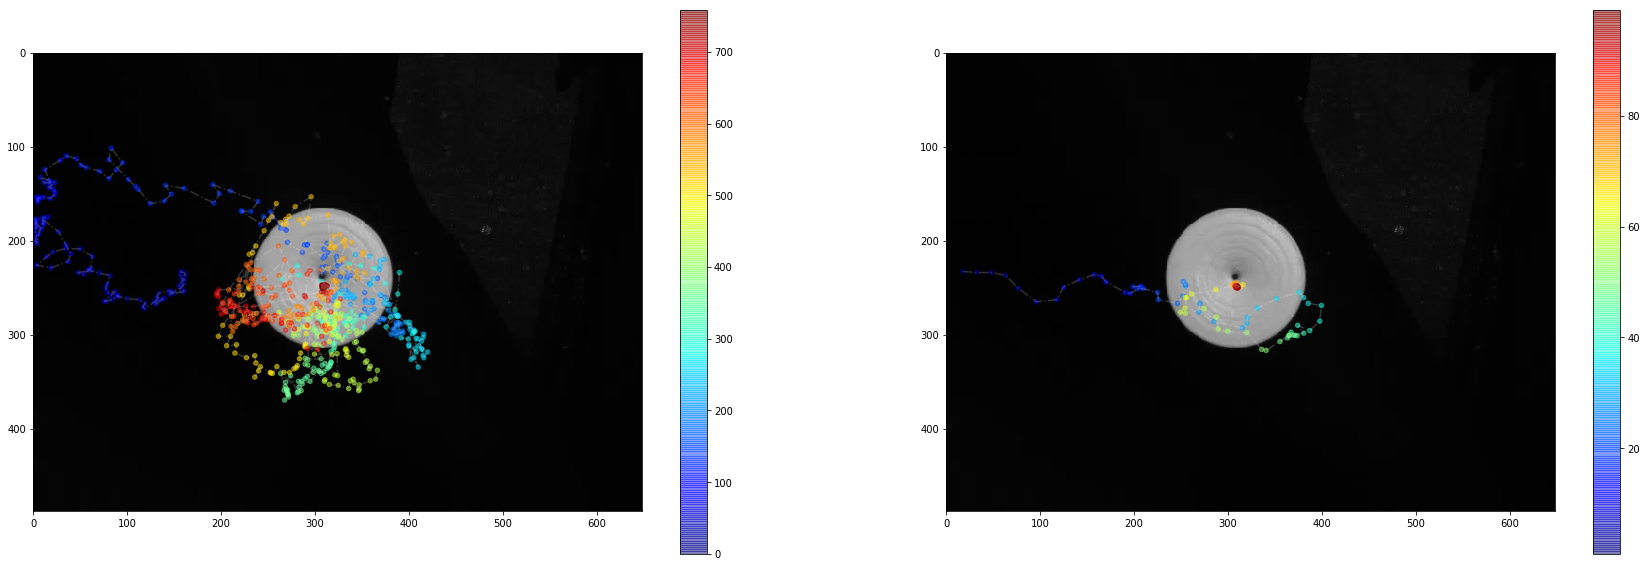

In [17]:
fig, ax = plt.subplots(1,2, figsize = (30,10) )

ax[0].imshow(frame)
t = np.arange(len(trial0.index))
t0= ax[0].scatter(trial0.pt4_cam1_X, trial0.pt4_cam1_Y,
            s= 20, alpha = 0.5, 
            c=t, cmap = "jet")
fig.colorbar(t0, ax= ax[0])
ax[0].plot(trial0.pt4_cam1_X, trial0.pt4_cam1_Y, '-.', c = "whitesmoke", alpha = 0.2)
ax[0].set_xlim(0,width)
ax[0].set_ylim(height, 0)


ax[1].imshow(frame)
t = np.arange(len(trial_last.index))
t_last= ax[1].scatter(trial_last.pt4_cam1_X, trial_last.pt4_cam1_Y,
            s= 20, alpha = 0.5, 
            c=t, cmap = "jet")
fig.colorbar(t_last, ax= ax[1])
ax[1].plot(trial_last.pt4_cam1_X, trial_last.pt4_cam1_Y, '-.', c = "whitesmoke", alpha = 0.2)
ax[1].set_xlim(0,width)
ax[1].set_ylim(height, 0)

Plot probability of tip in center along radius

In [18]:
# import all the packages needed for Hough Transform
from skimage import color
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter, circle

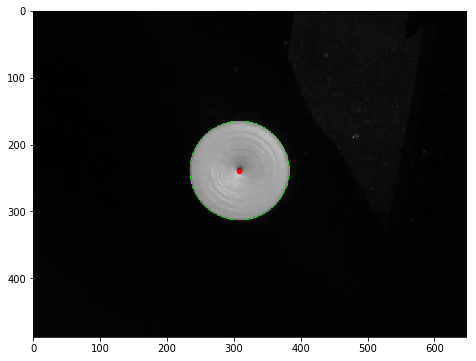

In [19]:
# find center and radius of flower

ret = vid.set(1,1)
# print(ret)
ret, frame = vid.read(1)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
# thresh = cv2.threshold(gray, 60 , 255, cv2.THRESH_BINARY)[1]

# Get the edges
edges = canny(blurred, sigma=5) 
# plt.imshow(edges, cmap='gray')

# perform the hough transform to get circles of radii close to 100
hough_radii = np.arange(50, 150, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(figsize=(10, 6))
bckgrnd_tmp = color.gray2rgb(frame)
plt.scatter(cx,cy, 20, c="red")
circy, circx = circle_perimeter(cy[0], cx[0], radii[0])
bckgrnd_tmp[circy, circx] = (20, 220, 20)

ax.imshow(bckgrnd_tmp, cmap='gray')

In [26]:
# center all the tracked points to the flower center and calculate r

new_x_t0 = trial0.pt4_cam1_X.values - cx[0]
new_y_t0 = trial0.pt4_cam1_Y.values - cy[0]
radius_t0 = np.linalg.norm([new_x_t0, new_y_t0], axis = 0)

new_x_tlast = trial_last.pt4_cam1_X.values - cx[0]
new_y_tlast = trial_last.pt4_cam1_Y.values - cy[0]
radius_tlast = np.linalg.norm([new_x_tlast, new_y_tlast], axis = 0)

In [27]:
useful_r_t0 = radius_t0[~np.isnan(radius_t0)]
useful_r_t0 = useful_r_t0[useful_r_t0 <= radii[0]]

useful_r_tlast = radius_tlast[~np.isnan(radius_tlast)]
useful_r_tlast = useful_r_tlast[useful_r_tlast <= radii[0]]

(array([35.,  0.,  1.,  0.,  0.,  1.,  7.,  7.,  6.,  4.]),
 array([0.07535122, 0.16217665, 0.24900209, 0.33582752, 0.42265296,
        0.5094784 , 0.59630383, 0.68312927, 0.7699547 , 0.85678014,
        0.94360558]),
 <a list of 10 Patch objects>)

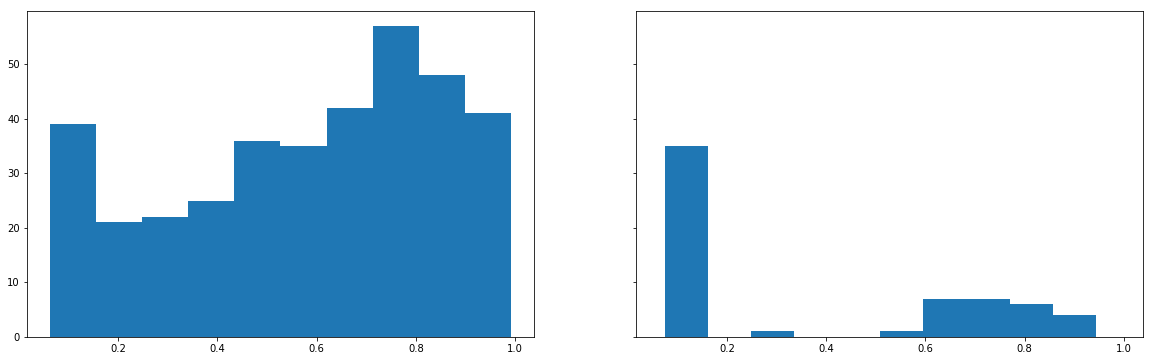

In [32]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (20,6))

ax[0].hist(useful_r_t0/radii[0])

ax[1].hist(useful_r_tlast/radii[0])

# Plot the tracks as heat maps

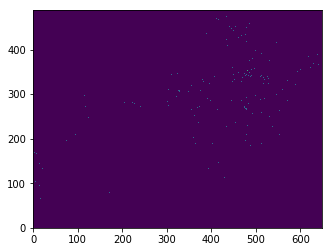

In [23]:
t0_heatmap, xedges, yedges = np.histogram2d(trial0.pt4_cam1_X[~np.isnan(trial0.pt4_cam1_X)],
                                            trial0.pt4_cam1_Y[~np.isnan(trial0.pt4_cam1_Y)],
                                            bins=(width,height))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(t0_heatmap.T, extent=[0, width, 0, height], origin='left')